In [4]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [5]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl

# setting parameters for default matplotlib plots
%matplotlib inline

In [6]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [7]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'modulation_index'

In [8]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
# load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [23]:
for session in ['3odor_pre', '3odor_post','3odor_pre_rev', '3odor_post_rev']:

    exec('vars_%s = {}'%session)
    folder = '../%s/notebooks/autorestore/preprocessing/'%session
    for var in ('time_ax', 'time_ax_single', 'traces', 'cycles',  'areas',
                'CS_DURATION', 'DELAY', 'is_CSmt', 'is_rewardt','is_sht'): 
        eval("vars_%s"%session).update({var:ut.load_variable(var, folder=folder)})
    folder = '../%s/notebooks/autorestore/selectivity/'%session
    for var in ('selectivity',): 
        eval("vars_%s"%session).update({var:ut.load_variable(var, folder=folder)})
#     folder = '../%s/notebooks/autorestore/decoding_odors_cs_and_trace/'%session
#     for var in ('patterns_evs', 'labels'): 
#         eval("vars_%s"%session).update({var:ut.load_variable(var, folder=folder)})

In [24]:
# conditions = ['day1', 'day2']
# cellregs = dict(zip(conditions, [ut.load_cellreg_dict('../data/cellreg_dict.txt', c) for c in conditions]))

In [25]:
import scipy.stats as sstats

In [26]:
from skimage.measure import find_contours
from skimage import exposure
from matplotlib.patches import Polygon

In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
vars_3odor_pre['selectivity'].keys()

['rewardt',
 'sht_tr',
 'CSmt_tr',
 'CSmt_us',
 'sht_us',
 'CSmt',
 'sht',
 'rewardt_tr',
 'rewardt_us']

In [29]:
pvalue = 0.05
# tuned_pre_rew = ut.adjust_pvalues([s[0][1] for s in vars_pre['selectivity']['reward_4s_us']])<pvalue
# tuned_pre_sho = ut.adjust_pvalues([s[0][1] for s in vars_pre['selectivity']['shock_4s_us']])<pvalue
# tuned_post_rew = ut.adjust_pvalues([s[0][1] for s in vars_post['selectivity']['reward_4s_us']])<pvalue
# tuned_post_sho = ut.adjust_pvalues([s[0][1] for s in vars_post['selectivity']['shock_4s_us']])<pvalue

In [30]:
def compute_modulation_index(time_ax, traces, cycles, time_ax_single, STIM_START, STIM_DURATION, is_odor, t_base=2):
    hm = np.r_[[ut.compute_all_dffs(time_ax, traces, cell, cycles[is_odor], time_ax_single)\
                        for cell in range(traces.shape[1])]]
    hm = np.r_[[np.mean(h, 0)/np.std(h, 0) for h in hm]]
    time_filter = (time_ax_single >= STIM_START) * (time_ax_single < (STIM_START + STIM_DURATION))
    stim_resp = hm[:, time_filter].mean(1)
    time_filter = (time_ax_single >= (STIM_START - t_base)) * (time_ax_single < STIM_START )
    base_resp = hm[:, time_filter].mean(1)
#     print zip(base_resp, stim_resp)
    return (stim_resp-base_resp)/base_resp*100.

In [31]:
from itertools import product

In [32]:
prod = product(['3odor_pre', '3odor_post','3odor_pre_rev', '3odor_post_rev'], ['CSmt', 'rewardt','sht'])

for session, odor in prod:
    v = eval("vars_%s"%session)
    exec("mod_inds_%s_%s = np.nan_to_num(compute_modulation_index(v['time_ax'],\
                                            v['traces'],\
                                            v['cycles'],\
                                            v['time_ax_single'],\
                                            0,\
                                            v['CS_DURATION']+v['DELAY'],\
                                            is_odor=v['is_%s']))"%(odor, session, odor))

In [33]:
prod = product(['3odor_pre', '3odor_post','3odor_pre_rev', '3odor_post_rev'], ['CSmt', 'rewardt','sht'])

for session, odor in prod:
    v = eval("vars_%s"%session)
    exec("mod_inds_only_tra%s_%s = np.nan_to_num(compute_modulation_index(v['time_ax'],\
                                            v['traces'],\
                                            v['cycles'],\
                                            v['time_ax_single'],\
                                            0,\
                                            v['CS_DURATION']+v['DELAY'],\
                                            is_odor=v['is_%s']))"%(odor, session, odor))

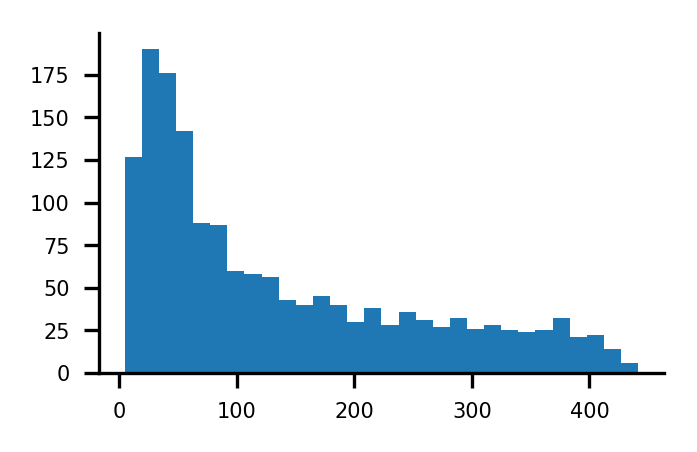

In [34]:
pl.hist(vars_3odor_pre['areas'][0].flatten()[np.nonzero(vars_3odor_pre['areas'][0].flatten())],bins=30);

In [35]:
# pl.style.use('white_background')
def plot_activity(vars_3odor_pre, odor='rewardt', tuned=None, with_untuned=True, ax=None, prepost='3odor_pre',
                  vmin=-75, vmax=75):
    
#     exec("vars_pre = vars_%s"%prepost)
    areas = vars_3odor_pre['areas'].copy()

    if ax is None:
        fig, ax = pl.subplots(1, 1, figsize=(3, 3))

    if tuned is None:
        tuned = [False]*len(areas)
    for cell in range(len(areas)):
#         p10 = np.percentile(areas[cell][np.nonzero(areas[cell])], 10)
#         p90 = np.percentile(areas[cell][np.nonzero(areas[cell])], 90)
        a = exposure.rescale_intensity(areas[cell], in_range=(np.min(areas[cell]), np.max(areas[cell])))
        contours = np.r_[find_contours(a, 0.01)]
        polygon = Polygon(contours[np.argmax([len(c) for c in contours])],
                          color=(0, 0, 0, 0), lw=0.5 if tuned[cell] else 0.1 if with_untuned else 0,
                          ec='k',
                          closed=False, zorder=19)
        ax.add_patch(polygon)
    # im = np.zeros_like(areas[0])

    # for a in areas:
    #     a = exposure.rescale_intensity(a, in_range=(0.2, 0.4))
    #     im += a
    # im = np.clip(im, 0, .2)
    # ax.imshow(im, pl.cm.gray, vmin=0, vmax=1)

    im2 = np.zeros_like(areas[0])
    for i, a in enumerate(areas):
    #     a = exposure.rescale_intensity(a, in_range=(0.2, 0.4))
        aa = a-np.min(a)
        aa /= np.max(aa)
#         aa *= 2
#         aa -= 1
        
#         a *= zz[vars_pre['labels']==odor][:, i].mean(0)
        a = aa*eval("mod_inds_%s_%s"%(odor, prepost))[i]
    #     a[a==0] = np.nan
        im2 += a

    # im2 /= 100.    
    im2[im2 == 0] = np.nan
    im2 = ax.imshow(im2.T, cmap=pl.cm.bwr, vmin=vmin, vmax=vmax)

    ax.set_xticks(())
    ax.set_yticks(());

    
    return im2

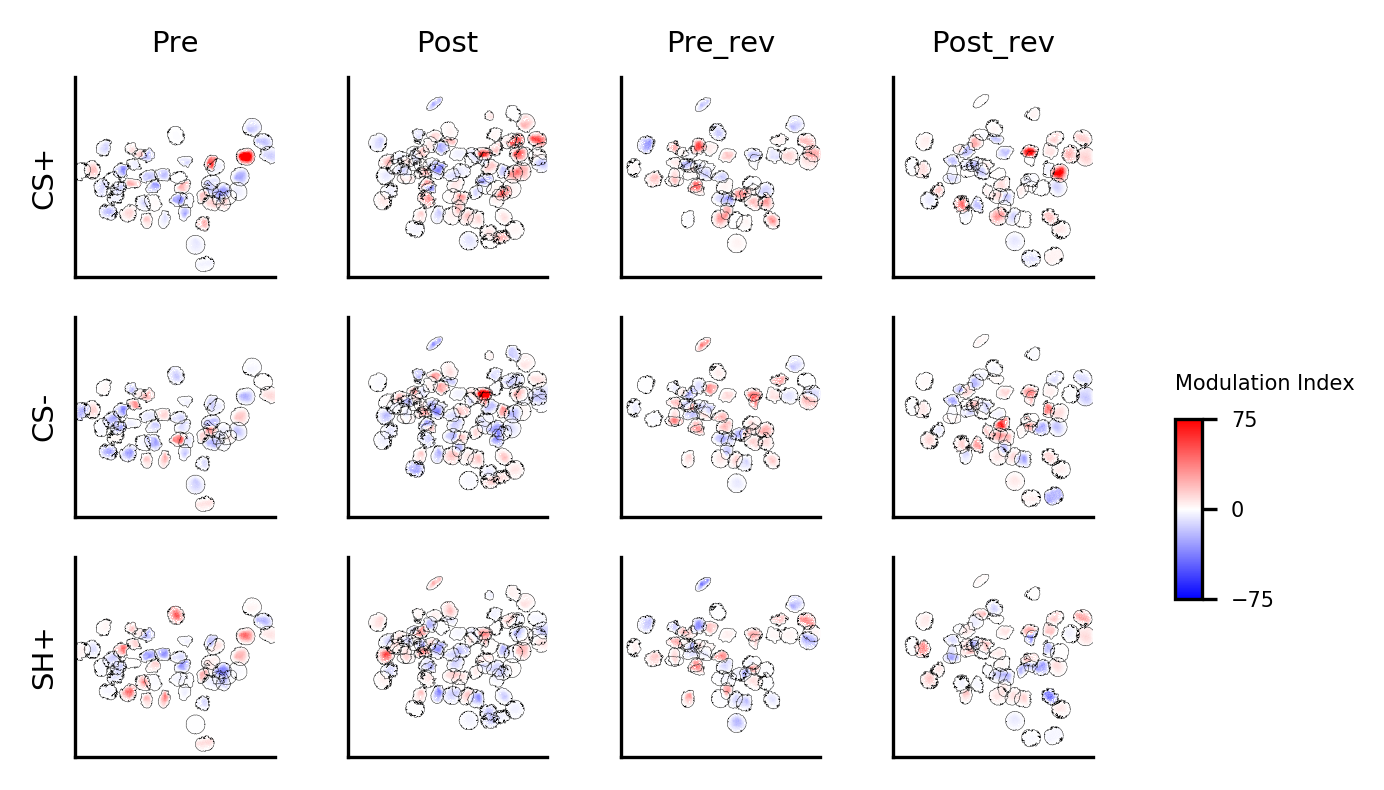

In [ ]:
abs_vmax_vmin = 75

fig, axs = pl.subplots(3, 4, figsize=(4.5, 3))
plot_activity(vars_3odor_pre, ax=axs[0][0], with_untuned=True,
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_3odor_post, ax=axs[0][1], prepost='3odor_post', with_untuned=True, 
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_3odor_pre_rev, ax=axs[0][2], prepost='3odor_pre_rev', with_untuned=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_3odor_post_rev, ax=axs[0][3], prepost='3odor_post_rev', with_untuned=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_3odor_pre, ax=axs[1][0], odor='CSmt', with_untuned=True, 
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_3odor_post, ax=axs[1][1], odor='CSmt', prepost='3odor_post', with_untuned=True, 
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_3odor_pre_rev, ax=axs[1][2], odor='CSmt', prepost='3odor_pre_rev', with_untuned=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_3odor_post_rev, ax=axs[1][3], odor='CSmt', prepost='3odor_post_rev', with_untuned=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_3odor_pre, ax=axs[2][0], odor='sht', with_untuned=True, 
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_3odor_post, ax=axs[2][1], odor='sht', prepost='3odor_post', with_untuned=True, 
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_3odor_pre_rev, ax=axs[2][2], odor='sht', prepost='3odor_pre_rev', with_untuned=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_3odor_post_rev, ax=axs[2][3], odor='sht', prepost='3odor_post_rev', with_untuned=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)


ax = fig.add_axes((0.95, 0.3, 0.02, 0.2))

fig.colorbar(im2, cax=ax, ticks=(-abs_vmax_vmin, 0, abs_vmax_vmin))

axs[0][0].set_title('Pre')
axs[0][1].set_title('Post')
axs[0][2].set_title('Pre_rev')
axs[0][3].set_title('Post_rev')



# fig.suptitle('Mean Event Rate\n(s.d.)', x=0.95, y=0.55, fontsize=5, ha='left')
fig.suptitle('Modulation Index', x=0.95, y=0.55, fontsize=5, ha='left')

axs[0][0].set_ylabel('CS+')
axs[1][0].set_ylabel('CS-')
axs[2][0].set_ylabel('SH+')

fig.savefig('../img/modulation_index.pdf')

In [ ]:
save_workspace(db)

Could not store variable 'di'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
